### Import Libraries

In [82]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

In [44]:
import os, subprocess

def ensure_java17():
    paths = [
        "/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home",
        "/usr/local/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home",
    ]
    for p in paths:
        if os.path.isdir(p):
            os.environ["JAVA_HOME"] = p
            os.environ["PATH"] = f"{p}/bin:" + os.environ.get("PATH", "")
            return p
    try:
        p = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).decode().strip()
        os.environ["JAVA_HOME"] = p
        os.environ["PATH"] = f"{p}/bin:" + os.environ.get("PATH", "")
        return p
    except Exception:
        return None

print("JAVA_HOME=", ensure_java17())
subprocess.run(["java", "-version"])

JAVA_HOME= /opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home


openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment Homebrew (build 17.0.17+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.17+0, mixed mode, sharing)


CompletedProcess(args=['java', '-version'], returncode=0)

### Set up Spark Environment

In [83]:
spark = SparkSession.builder \
    .appName("FlightDelayAnalysis") \
    .config("spark.executor.memory", "5g") \
    .config("spark.executor.cores", "3") \
    .config("spark.executor.instances", "4") \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.cores", "1") \
    .getOrCreate()

In [84]:
# increase the maximum number of fields that can be displayed when a plan is printed to 100

spark.conf.set("spark.sql.debug.maxToStringFields", "100")

### Loading Dataset

In [47]:
file = "Flight_Delay.parquet"

In [48]:
flights_whole_df = spark.read.format("parquet").load(file)

In [49]:
flights_whole_df.printSchema()

root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- FlightDate: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: double (nullable = true)
 |-- WheelsOn: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: long (nullabl

In [50]:
flights_whole_df.show(5)

+----+-----+----------+----------+-------------------------+--------------+--------------+----------+-------+--------+---------------+-------+---------+--------+------+----------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+-----------------+
|Year|Month|DayofMonth|FlightDate|Marketing_Airline_Network|OriginCityName|  DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|DistanceGroup|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|__index_level_0__|
+----+-----+----------+----------+-------------------------+--------------+--------------+----------+-------+--------+---------------+-------+---------+--------+------+----------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+

### Taking a sample of the data for testing

In [51]:
# Select relevant columns
flights_df = flights_whole_df.select(["FlightDate", "Marketing_Airline_Network", "CarrierDelay", "OriginCityName", "DestCityName", 
                                      "DepDelay", "ArrDelay", "ArrDelayMinutes", "DepTime","Distance"])\
							.sample(False, 0.001, 42)

In [52]:
flights_df.show(5)

+----------+-------------------------+------------+----------------+--------------+--------+--------+---------------+-------+--------+
|FlightDate|Marketing_Airline_Network|CarrierDelay|  OriginCityName|  DestCityName|DepDelay|ArrDelay|ArrDelayMinutes|DepTime|Distance|
+----------+-------------------------+------------+----------------+--------------+--------+--------+---------------+-------+--------+
|2018-01-09|                       DL|        52.0|     Atlanta, GA|    Moline, IL|    67.0|    52.0|           52.0| 1705.0|   633.0|
|2018-01-22|                       DL|         0.0|Grand Rapids, MI|  New York, NY|    -7.0|   -19.0|            0.0|  553.0|   618.0|
|2018-01-06|                       F9|         0.0|  Cincinnati, OH|Fort Myers, FL|   -10.0|   -12.0|            0.0|  650.0|   879.0|
|2018-01-16|                       F9|         0.0|      Denver, CO| Santa Ana, CA|    -7.0|   -26.0|            0.0| 1656.0|   846.0|
|2018-01-17|                       F9|         0.0|    

In [53]:
# Check the number of partitions
flights_df.rdd.getNumPartitions()

11

In [54]:
# Repartition the DataFrame into 10 partitions for parallel processing and better memory management

flights_df = flights_df.repartition(10)


### Understanding The data 

In [55]:
flights_df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Distance: double (nullable = true)



In [56]:
# For better performance, persist the DataFrame in memory
flights_df.persist()

DataFrame[FlightDate: string, Marketing_Airline_Network: string, CarrierDelay: double, OriginCityName: string, DestCityName: string, DepDelay: double, ArrDelay: double, ArrDelayMinutes: double, DepTime: double, Distance: double]

In [57]:
# Count the number of rows in the DataFrame
number_of_rows = flights_df.count()

print("Number of rows in the DataFrame: ", number_of_rows)

Number of rows in the DataFrame:  30116


In [58]:
numeric = {'double','float','int','bigint','long','short','decimal'}
exprs = [count(when(col(c).isNull() | (isnan(c) if t in numeric else lit(False)), c)).alias(c) for c,t in flights_df.dtypes]
flights_df.select(exprs).show()

+----------+-------------------------+------------+--------------+------------+--------+--------+---------------+-------+--------+
|FlightDate|Marketing_Airline_Network|CarrierDelay|OriginCityName|DestCityName|DepDelay|ArrDelay|ArrDelayMinutes|DepTime|Distance|
+----------+-------------------------+------------+--------------+------------+--------+--------+---------------+-------+--------+
|         0|                        0|           0|             0|           0|       0|       0|              0|      0|       0|
+----------+-------------------------+------------+--------------+------------+--------+--------+---------------+-------+--------+



In [59]:
# show the number of duplicates in the DataFrame

number_of_duplicates =  flights_df.count() - flights_df.dropDuplicates().count()

print("\nNumber of duplicates in the DataFrame: ", number_of_duplicates)


Number of duplicates in the DataFrame:  0


In [60]:
flights_df.describe().show()

+-------+----------+-------------------------+-----------------+--------------+------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|FlightDate|Marketing_Airline_Network|     CarrierDelay|OriginCityName|DestCityName|          DepDelay|          ArrDelay|  ArrDelayMinutes|           DepTime|         Distance|
+-------+----------+-------------------------+-----------------+--------------+------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|     30116|                    30116|            30116|         30116|       30116|             30116|             30116|            30116|             30116|            30116|
|   mean|      NULL|                     NULL|5.028456634347191|          NULL|        NULL|10.767166954442821| 3.843471908620003|14.54701819630761| 1327.119404967459|779.7922366848187|
| stddev|      NULL|                     NULL|33.64670317662585|      

### Preprocess the data

In [61]:
# Convert FlightDate to date type
flights_df1 = flights_df.withColumn("FlightDate", flights_df["FlightDate"].cast("date"))

In [62]:
flights_df1.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Distance: double (nullable = true)



In [63]:
# The total delay for each flight
flights_df2 = flights_df1.withColumn("TotalDelay", flights_df1["DepDelay"] + flights_df1["ArrDelay"])

In [64]:
flights_df2.select('Marketing_Airline_Network','TotalDelay').show(5)

+-------------------------+----------+
|Marketing_Airline_Network|TotalDelay|
+-------------------------+----------+
|                       AA|      27.0|
|                       UA|      71.0|
|                       WN|     -17.0|
|                       WN|     -25.0|
|                       AA|     162.0|
+-------------------------+----------+
only showing top 5 rows


In [65]:
# Mapping Marketing_Airline_Network to Carrier Name in a new column

flights_df3 = flights_df2.withColumn('Carrier_Name',when(col('Marketing_Airline_Network')=='AA','American Airlines')\
.when(col('Marketing_Airline_Network')=='AS','Alaska Airlines')\
.when(col('Marketing_Airline_Network')=='B6','JetBlue Airways')\
.when(col('Marketing_Airline_Network')=='DL','Delta Air Lines')\
.when(col('Marketing_Airline_Network')=='F9','Frontier Airlines')\
.when(col('Marketing_Airline_Network')=='G4','Allegiant Air')\
.when(col('Marketing_Airline_Network')=='HA','Hawaiian Airlines')\
.when(col('Marketing_Airline_Network')=='NK','Spirit Airlines')\
.when(col('Marketing_Airline_Network')=='UA','United Airlines')\
.when(col('Marketing_Airline_Network')=='VX','Virgin America')\
.when(col('Marketing_Airline_Network')=='WN','Southwest Airlines')\
.otherwise('Others'))

In [66]:
flights_df3.select("Carrier_Name").distinct().show()

+------------------+
|      Carrier_Name|
+------------------+
|     Allegiant Air|
|   United Airlines|
|    Virgin America|
| Hawaiian Airlines|
| Frontier Airlines|
| American Airlines|
|   Delta Air Lines|
|   JetBlue Airways|
|   Alaska Airlines|
|   Spirit Airlines|
|Southwest Airlines|
+------------------+



In [67]:
# map OriginCityName to Origin_City in a new column and DestCityName to Dest_City in a new column

flights_df4 = flights_df3.withColumn('Origin_City',when(col('OriginCityName')=='Atlanta, GA','Atlanta')\
.when(col('OriginCityName')=='Boston, MA','Boston')\
.when(col('OriginCityName')=='Charlotte, NC','Charlotte')\
.when(col('OriginCityName')=='Chicago, IL','Chicago')\
.when(col('OriginCityName')=='Dallas/Fort Worth, TX','Dallas')\
.when(col('OriginCityName')=='Denver, CO','Denver')\
.when(col('OriginCityName')=='Detroit, MI','Detroit')\
.when(col('OriginCityName')=='Houston, TX','Houston')\
.when(col('OriginCityName')=='Las Vegas, NV','Las Vegas')\
.when(col('OriginCityName')=='Los Angeles, CA','Los Angeles')\
.when(col('OriginCityName')=='Miami, FL','Miami')\
.when(col('OriginCityName')=='Minneapolis, MN','Minneapolis')\
.when(col('OriginCityName')=='New York, NY','New York')\
.when(col('OriginCityName')=='Orlando, FL','Orlando')\
.when(col('OriginCityName')=='Philadelphia, PA','Philadelphia')\
.when(col('OriginCityName')=='Phoenix, AZ','Phoenix')\
.when(col('OriginCityName')=='San Francisco, CA','San Francisco')\
.when(col('OriginCityName')=='Seattle, WA','Seattle')\
.when(col('OriginCityName')=='Washington, DC','Washington')\
.otherwise('Others'))

In [68]:
flights_df4.select("Origin_City").distinct().show()

+-------------+
|  Origin_City|
+-------------+
|      Phoenix|
|       Dallas|
| Philadelphia|
|  Los Angeles|
|San Francisco|
|      Detroit|
|   Washington|
|      Chicago|
|      Atlanta|
|    Las Vegas|
|      Seattle|
|       Others|
|  Minneapolis|
|      Houston|
|        Miami|
|      Orlando|
|     New York|
|    Charlotte|
|       Denver|
|       Boston|
+-------------+



In [69]:
flights_final_df = flights_df4.withColumn('Dest_City',when(col('DestCityName')=='Atlanta, GA','Atlanta')\
.when(col('DestCityName')=='Boston, MA','Boston')\
.when(col('DestCityName')=='Charlotte, NC','Charlotte')\
.when(col('DestCityName')=='Chicago, IL','Chicago')\
.when(col('DestCityName')=='Dallas/Fort Worth, TX','Dallas')\
.when(col('DestCityName')=='Denver, CO','Denver')\
.when(col('DestCityName')=='Detroit, MI','Detroit')\
.when(col('DestCityName')=='Houston, TX','Houston')\
.when(col('DestCityName')=='Las Vegas, NV','Las Vegas')\
.when(col('DestCityName')=='Los Angeles, CA','Los Angeles')\
.when(col('DestCityName')=='Miami, FL','Miami')\
.when(col('DestCityName')=='Minneapolis, MN','Minneapolis')\
.when(col('DestCityName')=='New York, NY','New York')\
.when(col('DestCityName')=='Orlando, FL','Orlando')\
.when(col('DestCityName')=='Philadelphia, PA','Philadelphia')\
.when(col('DestCityName')=='Phoenix, AZ','Phoenix')\
.when(col('DestCityName')=='San Francisco, CA','San Francisco')\
.when(col('DestCityName')=='Seattle, WA','Seattle')\
.when(col('DestCityName')=='Washington, DC','Washington')\
.otherwise('Others'))


In [70]:
flights_final_df.select("Dest_City").distinct().show()

+-------------+
|    Dest_City|
+-------------+
|      Phoenix|
|       Dallas|
| Philadelphia|
|  Los Angeles|
|San Francisco|
|      Detroit|
|   Washington|
|      Chicago|
|      Atlanta|
|    Las Vegas|
|      Seattle|
|       Others|
|  Minneapolis|
|      Houston|
|        Miami|
|      Orlando|
|     New York|
|    Charlotte|
|       Denver|
|       Boston|
+-------------+



In [71]:
flights_final_df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TotalDelay: double (nullable = true)
 |-- Carrier_Name: string (nullable = false)
 |-- Origin_City: string (nullable = false)
 |-- Dest_City: string (nullable = false)



In [72]:
# Cache the final processed DataFrame in memory for faster access
flights_final_df.cache()

DataFrame[FlightDate: date, Marketing_Airline_Network: string, CarrierDelay: double, OriginCityName: string, DestCityName: string, DepDelay: double, ArrDelay: double, ArrDelayMinutes: double, DepTime: double, Distance: double, TotalDelay: double, Carrier_Name: string, Origin_City: string, Dest_City: string]

### Analyze the dataset

In [73]:
# What is the average delay time for each airline? 

flights_final_df.groupBy("Carrier_Name").agg(avg("TotalDelay")).show()


+------------------+------------------+
|      Carrier_Name|   avg(TotalDelay)|
+------------------+------------------+
|     Allegiant Air| 27.84233261339093|
|   United Airlines| 20.12172984516818|
|    Virgin America| 23.22222222222222|
| Hawaiian Airlines|10.759493670886076|
| Frontier Airlines|25.607272727272726|
| American Airlines|14.882148824058604|
|   Delta Air Lines| 8.992021676953184|
|   JetBlue Airways| 27.10608695652174|
|   Alaska Airlines| 3.812221514958625|
|   Spirit Airlines|18.442528735632184|
|Southwest Airlines|13.129308666017527|
+------------------+------------------+



In [74]:
# what the top 10 airlines with the most delay time?

flights_final_df.groupBy("Carrier_Name").agg(sum("TotalDelay").alias("Total_Delay_Time")).orderBy(desc("Total_Delay_Time")).show(10)


+------------------+----------------+
|      Carrier_Name|Total_Delay_Time|
+------------------+----------------+
| American Airlines|        115798.0|
|   United Airlines|        113064.0|
|Southwest Airlines|         67419.0|
|   Delta Air Lines|         59734.0|
|   JetBlue Airways|         31172.0|
|   Spirit Airlines|         16045.0|
| Frontier Airlines|         14084.0|
|     Allegiant Air|         12891.0|
|   Alaska Airlines|          5989.0|
| Hawaiian Airlines|          3400.0|
+------------------+----------------+
only showing top 10 rows


In [75]:
# What is the most common cause of delays?

flights_final_df.groupBy("CarrierDelay").count().orderBy(desc("count")).show()

+------------+-----+
|CarrierDelay|count|
+------------+-----+
|         0.0|26663|
|         1.0|  115|
|         8.0|  107|
|         2.0|  107|
|        16.0|  103|
|        15.0|  101|
|         5.0|  101|
|         4.0|  100|
|         3.0|   96|
|         6.0|   92|
|         9.0|   91|
|        19.0|   84|
|        10.0|   82|
|        18.0|   81|
|        17.0|   80|
|         7.0|   78|
|        11.0|   78|
|        12.0|   75|
|        23.0|   73|
|        14.0|   71|
+------------+-----+
only showing top 20 rows


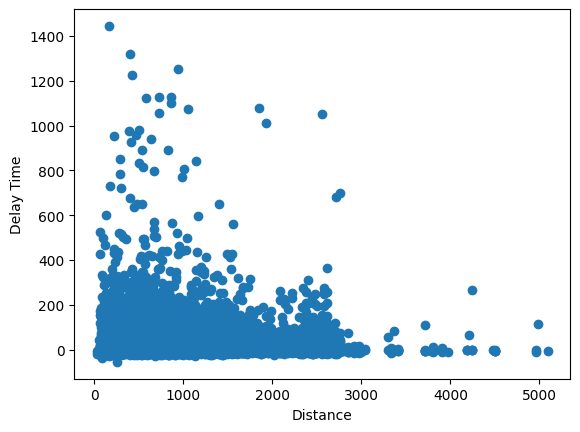

In [76]:
# What is the relationship between distance and delay time?

plt.scatter(flights_final_df.select("Distance").collect(), flights_final_df.select("DepDelay").collect())
plt.xlabel("Distance")
plt.ylabel("Delay Time")
plt.show()


In [85]:
# What is the busiest airport in terms of flight volume?
flights_final_df.groupBy("OriginCityName").count().orderBy(desc("count")).show()

+--------------------+-----+
|      OriginCityName|count|
+--------------------+-----+
|         Chicago, IL| 1679|
|         Atlanta, GA| 1464|
|Dallas/Fort Worth...| 1144|
|        New York, NY| 1126|
|          Denver, CO| 1111|
|       Charlotte, NC|  955|
|     Los Angeles, CA|  945|
|         Houston, TX|  883|
|      Washington, DC|  874|
|         Seattle, WA|  749|
|         Phoenix, AZ|  725|
|         Detroit, MI|  645|
|       Las Vegas, NV|  640|
|          Boston, MA|  609|
|   San Francisco, CA|  603|
|         Orlando, FL|  592|
|     Minneapolis, MN|  587|
|          Newark, NJ|  554|
|    Philadelphia, PA|  533|
|  Salt Lake City, UT|  519|
+--------------------+-----+
only showing top 20 rows


In [78]:
# what is the average delay time by day of week?
flights_final_df.groupBy(dayofweek("FlightDate").alias("DayOfWeek")).agg({"ArrDelayMinutes": "avg"}).orderBy("DayOfWeek").show()

+---------+--------------------+
|DayOfWeek|avg(ArrDelayMinutes)|
+---------+--------------------+
|        1|  15.466864716636197|
|        2|  13.931479421579533|
|        3|   13.62688352068883|
|        4|  13.450618725192623|
|        5|   14.63502824858757|
|        6|   16.67425764679616|
|        7|  13.867939128191901|
+---------+--------------------+



In [79]:
# what is the average delay time by month?

flights_final_df.groupBy(month("FlightDate").alias("Month")).agg(avg("TotalDelay").alias("Average_Delay_Time")).orderBy(desc("Average_Delay_Time")).show(12)

+-----+------------------+
|Month|Average_Delay_Time|
+-----+------------------+
|    6|28.575244879786286|
|   12|24.073382544507165|
|    7|21.629007633587786|
|    8| 21.00284090909091|
|    2|17.169972773239984|
|    1|12.603346113628442|
|    4|12.515483383685801|
|    3| 11.07208387942333|
|    5| 9.640610545790935|
|   10| 6.209450830140486|
|   11| 6.140579101972304|
|    9| 5.992650061249489|
+-----+------------------+



In [87]:
# Minimal prediction: classify if arrival delay >= 15 minutes
from pyspark.sql.functions import col, month, dayofweek
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# label
ml_df = flights_final_df.withColumn("Delayed15", (col("ArrDelayMinutes") >= 15).cast("int"))

# features
cat_cols = ["Carrier_Name", "Origin_City", "Dest_City"]
num_cols = ["Distance",]

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_oh") for c in cat_cols]
assembler = VectorAssembler(
    inputCols=[*(f"{c}_oh" for c in cat_cols), *num_cols],
    outputCol="features",
    handleInvalid="keep",
)

lr = LogisticRegression(featuresCol="features", labelCol="Delayed15", maxIter=20)

pipeline = Pipeline(stages=[*indexers, *encoders, assembler, lr])

train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

pred = model.transform(test_df)

# evaluate
auc = BinaryClassificationEvaluator(labelCol="Delayed15", rawPredictionCol="rawPrediction").evaluate(pred)
print("AUC=", auc)

# sample predictions
pred.select(
    "Carrier_Name", "Origin_City", "Dest_City", "Distance", "ArrDelayMinutes", "Delayed15", col("probability").alias("p")
).show(10, truncate=False)


25/11/05 16:00:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


AUC= 0.5481635112795072
+------------------+-----------+------------+--------+---------------+---------+----------------------------------------+
|Carrier_Name      |Origin_City|Dest_City   |Distance|ArrDelayMinutes|Delayed15|p                                       |
+------------------+-----------+------------+--------+---------------+---------+----------------------------------------+
|American Airlines |Los Angeles|Others      |1797.0  |0.0            |0        |[0.8092928919616713,0.1907071080383287] |
|Southwest Airlines|Atlanta    |Phoenix     |1587.0  |20.0           |1        |[0.7935404874392985,0.2064595125607015] |
|Delta Air Lines   |Las Vegas  |Others      |386.0   |0.0            |0        |[0.8313362632461258,0.16866373675387425]|
|United Airlines   |Others     |Denver      |250.0   |0.0            |0        |[0.7997947148231919,0.20020528517680813]|
|United Airlines   |Others     |Others      |725.0   |0.0            |0        |[0.7904742949569928,0.20952570504300716]|


In [ ]:
spark.stop()